In [25]:
import importlib
import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F

from utils import layers, hooking, img, stats, models, losses
from stepping import loss, closure

In [26]:
vgg = models.vgg19()

In [27]:
hooker = hooking.Hooker(vgg)
hooker.attach_hooks("texture_hooks", [3, 6, 19, 26, 37])
hook_bag = hooker.get_bag()
vgg = layers.clipped_model(vgg, hooker.last_hooked_index())

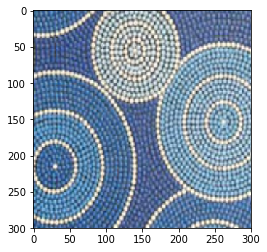

In [28]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.ToTensor(),
])

example_texture = img.image_loader("data/original/rings-2.jpg", transform)
img.show_image(example_texture)

In [29]:
vgg(example_texture)
target = stats.extract_features(hook_bag.get_hook("texture_hooks"), stats.gram_matrix)

def texture_loss_fn(target_grams, sample_features):
    sample_grams = [stats.gram_matrix(feature) for feature in sample_features]
    loss = 0
    
    for i in range(len(sample_grams)):
        loss += F.mse_loss(sample_grams[i], target_grams[i])
    
    return loss * 1000000

texture_loss = loss.LossFn(target, hook_bag.get_hook("texture_hooks"), texture_loss_fn)

def smooth_loss(target_grams, sample_features):
    loss = 0
    for layer in sample_features:
        loss += losses.smoothing_loss(layer)
    print("loss:{}".format(loss))
    return loss * 1000000

smoothness_loss = loss.LossFn(None, hook_bag.get_hook("texture_hooks"), smooth_loss) 

In [30]:
collector = loss.LossCollector()
collector.add_loss_fn("texture", texture_loss)
collector.add_loss_fn("texture", smoothness_loss)

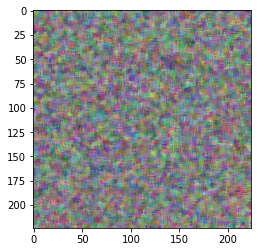

In [31]:
sample_texture = img.random_image(5, 224)
img.show_image(sample_texture)

inputs = {
    "input": sample_texture,
    "loss_name": "texture",
    "pyramid": False,
}

optimizer = optim.LBFGS([sample_texture])

In [33]:
stepper = closure.Stepper(inputs, vgg, collector, optimizer)

In [ ]:
importlib.reload(stats)
importlib.reload(losses)

show_at = 1
for i in range(129):
    optimizer.step(stepper.loss_fn)
    
    if i == show_at:
        show_at *= 2
        img.save_image(sample_texture, "data/synth/smooth{}.jpg".format(i))
    print(sample_texture.grad)

tensot rum: 1976357.0
tensor(27272384., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2727.2375, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25687386., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 7.9998, 7.9998,  ..., 7.9970, 7.9983, 7.9996],
         [7.9990, 7.9985, 7.9987,  ..., 8.0000, 8.0000, 8.0000],
         [7.9989, 7.9958, 7.9982,  ..., 7.9999, 7.9999, 7.9999],
         ...,
         [7.9998, 7.9998, 7.9998,  ..., 7.9994, 7.9989, 7.9995],
         [7.9960, 7.9982, 7.9998,  ..., 7.9994, 7.9980, 7.9987],
         [7.9975, 7.9986, 7.9998,  ..., 7.9982, 7.9950, 7.9987]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(27272062., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2727.2053, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25687386., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 7.9998, 7.9998,  ..., 7.9970, 7.9983, 7.9996],
         [7.9990, 7.9985, 7.9987,  ..., 8.0000, 8.0000, 8.0000],
         [7.9989, 7.9958, 7.9982,  ..., 7.9999, 7.9999, 7.9999],
         ...,
         [7.9998, 7.9998, 7.9998,  ..., 7.9994, 7.9989, 7.9995],
         [7.9960, 7.9982, 7.9998,  ..., 7.9994, 7.9980, 7.9987],
         [7.9975, 7.9986, 7.9998,  ..., 7.9982, 7.9950, 7.9987]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 1982360.0
tensor(27388464., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2738.8459, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25687374., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 7.9998, 7.9998,  ..., 7.9968, 7.9983, 7.9996],
         [7.9992, 7.9988, 7.9989,  ..., 8.0000, 8.0000, 8.0000],
         [7.9991, 7.9968, 7.9986,  ..., 7.9999, 7.9999, 7.9999],
         ...,
         [7.9998, 7.9998, 7.9998,  ..., 7.9991, 7.9987, 7.9994],
         [7.9963, 7.9984, 7.9998,  ..., 7.9990, 7.9980, 7.9986],
         [7.9976, 7.9986, 7.9998,  ..., 7.9981, 7.9950, 7.9986]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(28073826., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2807.3818, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25687308., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 7.9999, 7.9999,  ..., 7.9965, 7.9982, 7.9996],
         [7.9995, 7.9991, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         [7.9992, 7.9978, 7.9989,  ..., 7.9999, 7.9999, 7.9999],
         ...,
         [7.9998, 7.9998, 7.9998,  ..., 7.9991, 7.9986, 7.9994],
         [7.9965, 7.9986, 7.9998,  ..., 7.9988, 7.9982, 7.9986],
         [7.9977, 7.9985, 7.9998,  ..., 7.9981, 7.9951, 7.9987]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 7.9999, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 7.9999, 7.9998,  ..., 7.9999, 7.9999, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2156079.5
tensor(38685236., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3868.5232, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686248., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9952, 7.9978, 7.9992],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 7.9990],
         [8.0000, 8.0000, 8.0000,  ..., 7.9998, 7.9998, 7.9999],
         ...,
         [7.9999, 7.9999, 7.9999,  ..., 7.9993, 7.9987, 7.9992],
         [7.9976, 7.9994, 7.9999,  ..., 7.9990, 7.9991, 7.9986],
         [7.9981, 7.9981, 7.9996,  ..., 7.9979, 7.9957, 7.9986]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 7.9999, 7.9998,  ..., 8.0000, 8.0000,

tensot rum: 2242855.0
tensor(44769688., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4476.9683, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685642., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9955, 7.9979, 7.9991],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9982],
         [8.0000, 8.0000, 8.0000,  ..., 7.9997, 7.9998, 7.9999],
         ...,
         [7.9999, 7.9999, 7.9999,  ..., 7.9993, 7.9990, 7.9994],
         [7.9980, 7.9995, 7.9999,  ..., 7.9993, 7.9992, 7.9984],
         [7.9981, 7.9978, 7.9994,  ..., 7.9975, 7.9952, 7.9984]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9999, 7.9997,  ..., 8.0000, 8.0000,

tensor(49333852., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4933.3853, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685186., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9961, 7.9984, 7.9992],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9978],
         [8.0000, 8.0000, 8.0000,  ..., 7.9995, 7.9996, 7.9999],
         ...,
         [7.9999, 7.9999, 7.9999,  ..., 7.9993, 7.9993, 7.9996],
         [7.9983, 7.9996, 7.9999,  ..., 7.9996, 7.9988, 7.9980],
         [7.9981, 7.9975, 7.9992,  ..., 7.9964, 7.9944, 7.9982]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9999, 7.9997,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2345820.0
tensor(52232168., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5223.2168, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25684900., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9972, 7.9990, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9977],
         [8.0000, 7.9999, 7.9999,  ..., 7.9993, 7.9995, 7.9999],
         ...,
         [8.0000, 8.0000, 7.9999,  ..., 7.9992, 7.9995, 7.9997],
         [7.9985, 7.9996, 7.9999,  ..., 7.9997, 7.9978, 7.9973],
         [7.9981, 7.9973, 7.9990,  ..., 7.9952, 7.9933, 7.9979]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9999, 7.9997,  ..., 8.0000, 8.0000,

tensor(52572816., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5257.2812, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25684860., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9982, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9982],
         [7.9998, 7.9994, 7.9994,  ..., 7.9991, 7.9993, 7.9999],
         ...,
         [8.0000, 8.0000, 7.9999,  ..., 7.9994, 7.9995, 7.9996],
         [7.9987, 7.9996, 7.9999,  ..., 7.9996, 7.9967, 7.9967],
         [7.9980, 7.9973, 7.9988,  ..., 7.9943, 7.9925, 7.9977]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9999, 7.9997,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2348481.0
tensor(52172544., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5217.2539, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25684900., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9983, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9984],
         [7.9998, 7.9993, 7.9993,  ..., 7.9991, 7.9993, 7.9999],
         ...,
         [8.0000, 7.9999, 7.9999,  ..., 7.9994, 7.9995, 7.9996],
         [7.9987, 7.9996, 7.9999,  ..., 7.9996, 7.9966, 7.9967],
         [7.9980, 7.9973, 7.9988,  ..., 7.9943, 7.9924, 7.9977]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9999, 7.9997,  ..., 8.0000, 8.0000,

tensor(50793556., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5079.3555, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685038., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9987, 7.9997, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9988],
         [7.9997, 7.9991, 7.9991,  ..., 7.9991, 7.9993, 7.9999],
         ...,
         [7.9999, 7.9999, 7.9999,  ..., 7.9995, 7.9995, 7.9996],
         [7.9987, 7.9996, 7.9999,  ..., 7.9996, 7.9963, 7.9966],
         [7.9979, 7.9973, 7.9988,  ..., 7.9943, 7.9924, 7.9976]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9999, 7.9998,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2299808.75
tensor(48414308., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4841.4312, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685272., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9991, 7.9998, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [7.9995, 7.9985, 7.9984,  ..., 7.9991, 7.9993, 7.9998],
         ...,
         [7.9999, 7.9999, 7.9999,  ..., 7.9994, 7.9994, 7.9995],
         [7.9988, 7.9996, 7.9999,  ..., 7.9995, 7.9957, 7.9965],
         [7.9979, 7.9973, 7.9988,  ..., 7.9945, 7.9925, 7.9976]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000

tensor(45263208., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4526.3198, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685592., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9997, 7.9999, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9988, 7.9967, 7.9973,  ..., 7.9990, 7.9991, 7.9997],
         ...,
         [7.9999, 7.9999, 7.9998,  ..., 7.9993, 7.9993, 7.9994],
         [7.9989, 7.9996, 7.9997,  ..., 7.9993, 7.9950, 7.9965],
         [7.9979, 7.9975, 7.9988,  ..., 7.9954, 7.9931, 7.9978]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 7.9996, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2246573.5
tensor(44763972., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4476.3970, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685640., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9998, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9987, 7.9964, 7.9971,  ..., 7.9990, 7.9991, 7.9997],
         ...,
         [7.9999, 7.9999, 7.9998,  ..., 7.9993, 7.9994, 7.9994],
         [7.9991, 7.9996, 7.9996,  ..., 7.9994, 7.9953, 7.9967],
         [7.9980, 7.9974, 7.9986,  ..., 7.9959, 7.9937, 7.9979]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(43606132., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4360.6128, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685756., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9997, 7.9997, 7.9998],
         [8.0000, 8.0000, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         [7.9986, 7.9962, 7.9971,  ..., 7.9990, 7.9991, 7.9997],
         ...,
         [7.9999, 7.9999, 7.9998,  ..., 7.9993, 7.9995, 7.9993],
         [7.9992, 7.9996, 7.9996,  ..., 7.9994, 7.9957, 7.9969],
         [7.9980, 7.9974, 7.9986,  ..., 7.9963, 7.9941, 7.9981]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2223697.0
tensor(43382376., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4338.2368, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685784., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9997, 7.9997, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9987, 7.9964, 7.9971,  ..., 7.9990, 7.9991, 7.9997],
         ...,
         [7.9999, 7.9999, 7.9997,  ..., 7.9993, 7.9995, 7.9993],
         [7.9992, 7.9996, 7.9995,  ..., 7.9994, 7.9959, 7.9971],
         [7.9981, 7.9973, 7.9985,  ..., 7.9965, 7.9944, 7.9981]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(43710456., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4371.0454, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685744., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 7.9997, 7.9995, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9989, 7.9967, 7.9972,  ..., 7.9989, 7.9990, 7.9997],
         ...,
         [8.0000, 7.9999, 7.9996,  ..., 7.9993, 7.9993, 7.9991],
         [7.9995, 7.9997, 7.9993,  ..., 7.9992, 7.9965, 7.9975],
         [7.9982, 7.9971, 7.9979,  ..., 7.9971, 7.9953, 7.9983]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2231244.25
tensor(44403020., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4440.3027, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685676., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9996, 7.9993, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9992, 7.9974, 7.9974,  ..., 7.9989, 7.9990, 7.9997],
         ...,
         [8.0000, 7.9998, 7.9995,  ..., 7.9992, 7.9989, 7.9987],
         [7.9997, 7.9998, 7.9992,  ..., 7.9991, 7.9964, 7.9974],
         [7.9984, 7.9969, 7.9974,  ..., 7.9971, 7.9954, 7.9983]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor([[[[-4.2885e-02,  5.0890e-02,  3.6089e-02,  ...,  8.5726e-02,
            8.7904e-02,  5.5506e-02],
          [-2.3994e-02,  4.7199e-02,  7.0475e-02,  ...,  3.0876e-02,
           -5.4860e-03, -2.4667e-02],
          [-3.5857e-02,  1.3177e-01,  1.4317e-01,  ...,  3.0917e-02,
           -1.0674e-02,  6.9244e-02],
          ...,
          [ 4.0700e-02,  4.4489e-02,  5.5807e-02,  ...,  2.2314e-01,
            1.2675e-01,  3.8042e-02],
          [ 8.0446e-02, -6.2609e-03, -1.8300e-02,  ..., -3.7177e-02,
           -2.4455e-01,  1.9671e-02],
          [ 3.0880e-02,  3.6438e-02, -9.8554e-03,  ...,  9.9992e-03,
            1.4409e-02, -2.0255e-03]],

         [[-2.0289e-02,  3.7444e-02, -7.6124e-02,  ...,  5.8290e-02,
            4.5277e-02,  4.0712e-02],
          [ 1.6403e-02, -6.3497e-02, -2.4813e-01,  ..., -1.1134e-01,
           -1.6262e-01, -1.1153e-01],
          [ 1.3961e-02,  2.7336e-02, -1.5123e-01,  ..., -3.6593e-02,
           -1.1865e-01,  1.6382e-02],
          ...,
     

tensor(45123652., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4512.3652, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685606., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9997, 7.9993, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9993, 7.9977, 7.9976,  ..., 7.9989, 7.9991, 7.9996],
         ...,
         [8.0000, 7.9998, 7.9994,  ..., 7.9990, 7.9986, 7.9983],
         [7.9998, 7.9998, 7.9990,  ..., 7.9991, 7.9960, 7.9973],
         [7.9985, 7.9968, 7.9970,  ..., 7.9971, 7.9953, 7.9983]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2238729.5
tensor(45102704., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4510.2700, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685610., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 7.9999, 8.0000,  ..., 7.9997, 7.9993, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9993, 7.9978, 7.9977,  ..., 7.9990, 7.9991, 7.9996],
         ...,
         [8.0000, 7.9998, 7.9993,  ..., 7.9989, 7.9987, 7.9982],
         [7.9998, 7.9998, 7.9989,  ..., 7.9991, 7.9956, 7.9971],
         [7.9986, 7.9968, 7.9969,  ..., 7.9970, 7.9951, 7.9983]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(44727000., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4472.7002, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685646., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 7.9998, 8.0000,  ..., 7.9997, 7.9994, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9994, 7.9981, 7.9980,  ..., 7.9991, 7.9992, 7.9996],
         ...,
         [8.0000, 7.9998, 7.9992,  ..., 7.9987, 7.9986, 7.9979],
         [7.9999, 7.9998, 7.9988,  ..., 7.9991, 7.9946, 7.9967],
         [7.9987, 7.9970, 7.9967,  ..., 7.9968, 7.9946, 7.9982]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2220073.25
tensor(44142960., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4414.2964, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685700., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9991, 7.9991, 7.9995,  ..., 7.9999, 7.9996, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9996, 7.9987, 7.9987,  ..., 7.9995, 7.9995, 7.9997],
         ...,
         [8.0000, 7.9997, 7.9986,  ..., 7.9987, 7.9976, 7.9969],
         [7.9999, 7.9997, 7.9978,  ..., 7.9987, 7.9918, 7.9958],
         [7.9990, 7.9973, 7.9958,  ..., 7.9971, 7.9939, 7.9980]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(43571928., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4357.1924, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685758., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9991, 7.9991, 7.9995,  ..., 7.9999, 7.9996, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9996, 7.9987, 7.9987,  ..., 7.9995, 7.9996, 7.9997],
         ...,
         [8.0000, 7.9997, 7.9986,  ..., 7.9988, 7.9976, 7.9971],
         [7.9999, 7.9996, 7.9978,  ..., 7.9986, 7.9921, 7.9959],
         [7.9990, 7.9973, 7.9958,  ..., 7.9973, 7.9941, 7.9980]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2208429.25
tensor(43370984., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4337.0991, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685784., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9989, 7.9989, 7.9993,  ..., 7.9999, 7.9997, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9996, 7.9989, 7.9989,  ..., 7.9997, 7.9997, 7.9997],
         ...,
         [8.0000, 7.9996, 7.9984,  ..., 7.9987, 7.9972, 7.9971],
         [7.9999, 7.9996, 7.9975,  ..., 7.9985, 7.9916, 7.9959],
         [7.9991, 7.9974, 7.9956,  ..., 7.9975, 7.9941, 7.9980]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(43241464., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4324.1470, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685796., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9990, 7.9990, 7.9993,  ..., 7.9999, 7.9997, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9996, 7.9989, 7.9988,  ..., 7.9997, 7.9997, 7.9997],
         ...,
         [8.0000, 7.9996, 7.9984,  ..., 7.9987, 7.9972, 7.9972],
         [7.9999, 7.9996, 7.9975,  ..., 7.9985, 7.9920, 7.9961],
         [7.9991, 7.9974, 7.9956,  ..., 7.9976, 7.9943, 7.9980]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        ...,

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8., 

tensot rum: 2190909.0
tensor(42360548., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4236.0537, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685880., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9989, 7.9990, 7.9993,  ..., 7.9998, 7.9996, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9997, 7.9991, 7.9991,  ..., 7.9998, 7.9998, 7.9998],
         ...,
         [8.0000, 7.9996, 7.9984,  ..., 7.9984, 7.9966, 7.9977],
         [7.9998, 7.9995, 7.9974,  ..., 7.9981, 7.9929, 7.9967],
         [7.9992, 7.9976, 7.9956,  ..., 7.9979, 7.9950, 7.9982]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(42102864., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4210.2871, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685906., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9989, 7.9990, 7.9993,  ..., 7.9998, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9998, 7.9992, 7.9992,  ..., 7.9999, 7.9999, 7.9999],
         ...,
         [7.9999, 7.9996, 7.9983,  ..., 7.9981, 7.9963, 7.9979],
         [7.9998, 7.9995, 7.9973,  ..., 7.9979, 7.9933, 7.9969],
         [7.9992, 7.9977, 7.9956,  ..., 7.9980, 7.9953, 7.9982]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor(834681.6875, device='cuda:0', grad_fn=<SumBackward0>)
tensot rum: 1692.921630859375
tensor(14822.4355, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4822, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200702.5312, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8

tensor([[[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        ...,

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8., 

tensor(1841035.1250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-184.1035, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211080.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9992],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9910]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor([[[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.]],

        ...,

        [[8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8.,  ..., 8., 8., 8.],
         ...,
         [8., 8., 8.,  ..., 8., 8., 8.],
         [8., 8., 8., 

tensot rum: 2205490.0
tensor(43014768., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4301.4761, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685810., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9990, 7.9992, 7.9995,  ..., 7.9997, 7.9996, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9984,  ..., 7.9983, 7.9970, 7.9984],
         [7.9997, 7.9994, 7.9973,  ..., 7.9980, 7.9944, 7.9973],
         [7.9994, 7.9981, 7.9956,  ..., 7.9984, 7.9956, 7.9984]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(43355936., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4335.5938, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685780., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9989, 7.9993, 7.9995,  ..., 7.9997, 7.9996, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [8.0000, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9985,  ..., 7.9988, 7.9977, 7.9986],
         [7.9997, 7.9994, 7.9974,  ..., 7.9984, 7.9943, 7.9972],
         [7.9994, 7.9982, 7.9957,  ..., 7.9985, 7.9953, 7.9984]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2227846.0
tensor(44020528., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4402.0522, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685716., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9989, 7.9993, 7.9995,  ..., 7.9997, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [8.0000, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9995, 7.9985,  ..., 7.9991, 7.9983, 7.9987],
         [7.9997, 7.9994, 7.9973,  ..., 7.9988, 7.9943, 7.9971],
         [7.9995, 7.9984, 7.9959,  ..., 7.9987, 7.9951, 7.9984]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(43576680., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4357.6675, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685762., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9990, 7.9994, 7.9996,  ..., 7.9997, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [8.0000, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9995, 7.9986,  ..., 7.9992, 7.9986, 7.9988],
         [7.9997, 7.9994, 7.9975,  ..., 7.9989, 7.9944, 7.9970],
         [7.9995, 7.9984, 7.9961,  ..., 7.9988, 7.9950, 7.9984]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9991],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9922]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(59071120., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5907.1118, device='cuda:0', grad_fn=<SumBackward0>)
tensor(12839161., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 7.9979, 7.9979,  ..., 8.0000, 8.0000, 8.0000],
         [7.9440, 7.9979, 7.9841,  ..., 7.9962, 8.0000, 8.0000],
         [7.9897, 7.9979, 7.9979,  ..., 7.9877, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9991, 7.9955,  ..., 7.9983, 7.9999, 8.0000],
         [7.9758, 8.0000, 7.9964,  ..., 8.0000, 8.0000, 8.0000],
         [7.9789, 7.9880, 7.9992,  ..., 8.0000, 8.0000, 8.0000]],

        [[7.9982, 8.0000, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         [7.9949, 8.0000, 7.9996,  ..., 7.9995, 8.0000, 8.0000],
         [8.0000, 8.0000, 7.9996,  ..., 7.9980, 7.9985, 7.9985],
         ...,
         [7.9943, 7.9690, 7.9942,  ..., 7.9986, 7.9997, 8.0000],
         [7.9817, 7.9942, 7.9948,  ..., 7.9993, 8.0000, 8.0000],
         [7.9929, 7.9995, 7.9995,  ..., 7.9999, 8.0000, 8.0000]],

        [[

tensor(42078956., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4207.8960, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685908., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9991, 7.9995, 7.9996,  ..., 7.9996, 7.9995, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [8.0000, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9987,  ..., 7.9992, 7.9986, 7.9989],
         [7.9997, 7.9994, 7.9976,  ..., 7.9990, 7.9947, 7.9972],
         [7.9995, 7.9985, 7.9963,  ..., 7.9989, 7.9953, 7.9984]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2196899.75
tensor(42100864., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4210.0869, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685910., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9991, 7.9995, 7.9996,  ..., 7.9996, 7.9994, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [8.0000, 7.9998, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9995, 7.9987,  ..., 7.9993, 7.9986, 7.9990],
         [7.9997, 7.9993, 7.9976,  ..., 7.9990, 7.9950, 7.9974],
         [7.9996, 7.9986, 7.9965,  ..., 7.9990, 7.9957, 7.9985]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(42125368., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4212.5361, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685906., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9992, 7.9996, 7.9996,  ..., 7.9995, 7.9993, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [8.0000, 7.9998, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9988,  ..., 7.9993, 7.9988, 7.9991],
         [7.9997, 7.9993, 7.9976,  ..., 7.9991, 7.9954, 7.9976],
         [7.9996, 7.9987, 7.9966,  ..., 7.9991, 7.9961, 7.9986]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2195417.5
tensor(41817024., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4181.7026, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685934., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9993, 7.9997, 7.9997,  ..., 7.9994, 7.9992, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [8.0000, 7.9999, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9989,  ..., 7.9994, 7.9989, 7.9992],
         [7.9996, 7.9993, 7.9978,  ..., 7.9992, 7.9958, 7.9978],
         [7.9997, 7.9988, 7.9968,  ..., 7.9992, 7.9964, 7.9987]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(41599772., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4159.9775, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685954., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9994, 7.9997, 7.9997,  ..., 7.9993, 7.9991, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [8.0000, 7.9999, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9989,  ..., 7.9994, 7.9989, 7.9992],
         [7.9997, 7.9994, 7.9978,  ..., 7.9992, 7.9961, 7.9980],
         [7.9997, 7.9989, 7.9969,  ..., 7.9993, 7.9969, 7.9988]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2202221.25
tensor(41948652., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4194.8647, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685920., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9998, 7.9997,  ..., 7.9992, 7.9990, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [8.0000, 7.9999, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9990,  ..., 7.9995, 7.9990, 7.9993],
         [7.9997, 7.9994, 7.9980,  ..., 7.9993, 7.9967, 7.9983],
         [7.9998, 7.9990, 7.9971,  ..., 7.9994, 7.9975, 7.9990]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(41785312., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4178.5312, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685938., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9994, 7.9998, 7.9997,  ..., 7.9993, 7.9991, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [8.0000, 7.9999, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9990,  ..., 7.9995, 7.9989, 7.9993],
         [7.9997, 7.9995, 7.9979,  ..., 7.9993, 7.9965, 7.9982],
         [7.9998, 7.9989, 7.9970,  ..., 7.9994, 7.9973, 7.9990]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2202695.75
tensor(41930920., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4193.0923, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685920., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9998, 7.9997,  ..., 7.9993, 7.9991, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [8.0000, 7.9999, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9996, 7.9990,  ..., 7.9995, 7.9990, 7.9993],
         [7.9997, 7.9995, 7.9980,  ..., 7.9993, 7.9966, 7.9983],
         [7.9998, 7.9989, 7.9970,  ..., 7.9994, 7.9974, 7.9990]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(42602820., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4260.2827, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685850., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9998, 7.9997,  ..., 7.9994, 7.9992, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9992],
         [8.0000, 7.9999, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9992,  ..., 7.9996, 7.9992, 7.9994],
         [7.9998, 7.9996, 7.9982,  ..., 7.9994, 7.9970, 7.9985],
         [7.9998, 7.9990, 7.9971,  ..., 7.9994, 7.9978, 7.9992]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2234820.5
tensor(43252376., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4325.2368, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685788., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9996, 7.9999, 7.9997,  ..., 7.9995, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9991],
         [8.0000, 7.9999, 7.9999,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9993,  ..., 7.9996, 7.9993, 7.9995],
         [7.9998, 7.9996, 7.9983,  ..., 7.9994, 7.9975, 7.9988],
         [7.9999, 7.9991, 7.9972,  ..., 7.9993, 7.9983, 7.9993]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(43091536., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4309.1528, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685810., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9998, 7.9997,  ..., 7.9996, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9991],
         [8.0000, 7.9999, 7.9998,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9993,  ..., 7.9996, 7.9992, 7.9995],
         [7.9998, 7.9997, 7.9983,  ..., 7.9993, 7.9977, 7.9990],
         [7.9999, 7.9991, 7.9972,  ..., 7.9993, 7.9985, 7.9994]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2245517.0
tensor(43540168., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4354.0161, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685762., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9999, 7.9998,  ..., 7.9997, 7.9997, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9992],
         [8.0000, 7.9998, 7.9997,  ..., 7.9999, 7.9999, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9993,  ..., 7.9994, 7.9992, 7.9995],
         [7.9999, 7.9997, 7.9982,  ..., 7.9991, 7.9981, 7.9992],
         [7.9999, 7.9992, 7.9973,  ..., 7.9992, 7.9988, 7.9995]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(42997540., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4299.7539, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685816., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9998, 7.9998,  ..., 7.9997, 7.9997, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9993],
         [8.0000, 7.9998, 7.9996,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9992,  ..., 7.9993, 7.9991, 7.9995],
         [7.9998, 7.9997, 7.9981,  ..., 7.9991, 7.9980, 7.9992],
         [7.9999, 7.9992, 7.9972,  ..., 7.9993, 7.9988, 7.9995]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2235097.0
tensor(42893332., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4289.3320, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685826., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9999, 7.9998,  ..., 7.9997, 7.9997, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9993],
         [8.0000, 7.9997, 7.9995,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9992,  ..., 7.9992, 7.9990, 7.9995],
         [7.9998, 7.9996, 7.9980,  ..., 7.9990, 7.9982, 7.9993],
         [7.9999, 7.9992, 7.9973,  ..., 7.9993, 7.9988, 7.9995]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(42502012., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4250.2021, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685866., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9999, 7.9999,  ..., 7.9997, 7.9997, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9995],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9989, 7.9990, 7.9995],
         [7.9998, 7.9996, 7.9977,  ..., 7.9989, 7.9985, 7.9994],
         [7.9999, 7.9993, 7.9974,  ..., 7.9994, 7.9990, 7.9996]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2230076.75
tensor(42421464., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4242.1470, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685872., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9999, 7.9999,  ..., 7.9997, 7.9996, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9995],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9990, 7.9990, 7.9995],
         [7.9998, 7.9996, 7.9977,  ..., 7.9991, 7.9986, 7.9994],
         [7.9999, 7.9993, 7.9974,  ..., 7.9995, 7.9991, 7.9996]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(42306916., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4230.6904, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685884., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9995, 7.9999, 7.9999,  ..., 7.9997, 7.9996, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9995],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9990, 7.9990, 7.9995],
         [7.9998, 7.9996, 7.9977,  ..., 7.9991, 7.9987, 7.9994],
         [7.9999, 7.9993, 7.9974,  ..., 7.9995, 7.9991, 7.9997]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2221192.5
tensor(41794600., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4179.4600, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685938., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9996, 8.0000, 8.0000,  ..., 7.9996, 7.9995, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9995],
         [7.9999, 7.9995, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9989, 7.9990, 7.9995],
         [7.9999, 7.9996, 7.9978,  ..., 7.9991, 7.9989, 7.9995],
         [7.9999, 7.9994, 7.9975,  ..., 7.9995, 7.9992, 7.9997]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor([[[[-6.0069e-03,  8.4418e-03,  2.6159e-02,  ...,  2.0307e-03,
           -1.6443e-02,  2.3585e-04],
          [ 1.1894e-03, -1.9932e-02, -8.8264e-03,  ..., -4.2214e-03,
           -7.8501e-03, -6.4592e-03],
          [ 8.9658e-03,  1.3445e-02,  1.6565e-03,  ...,  3.9557e-02,
            2.4660e-02,  2.7767e-03],
          ...,
          [ 4.7919e-03,  1.5246e-02,  2.4164e-03,  ..., -2.0555e-02,
            3.7893e-02,  6.2041e-03],
          [ 2.5711e-03, -5.0477e-04, -5.0206e-03,  ...,  6.3890e-05,
            1.0061e-02, -5.7968e-04],
          [ 4.1448e-03, -1.0232e-03, -1.0534e-02,  ..., -8.1058e-03,
            3.3965e-03,  8.8169e-03]],

         [[-8.6694e-03,  8.3581e-03,  3.0002e-02,  ...,  1.5191e-02,
           -1.0215e-02,  4.8162e-03],
          [ 6.2635e-03, -2.6675e-02, -2.9471e-02,  ...,  4.4201e-03,
            7.4990e-03, -9.2065e-04],
          [ 3.1053e-03,  3.7666e-03, -1.6934e-02,  ...,  2.7066e-02,
            4.0465e-02,  8.9965e-03],
          ...,
     

tensor(41625456., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4162.5459, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685954., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9994, 7.9993, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9998, 7.9992],
         [8.0000, 7.9997, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9993,  ..., 7.9986, 7.9990, 7.9995],
         [7.9999, 7.9997, 7.9979,  ..., 7.9991, 7.9991, 7.9996],
         [8.0000, 7.9994, 7.9975,  ..., 7.9995, 7.9994, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2219109.75
tensor(41470920., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4147.0918, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685968., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9993, 7.9992, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9998, 7.9990],
         [8.0000, 7.9998, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9993,  ..., 7.9984, 7.9989, 7.9996],
         [7.9999, 7.9997, 7.9980,  ..., 7.9990, 7.9991, 7.9996],
         [8.0000, 7.9994, 7.9975,  ..., 7.9995, 7.9994, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(41687988., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4168.7983, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685946., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9992, 7.9991, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 7.9997, 7.9989],
         [8.0000, 7.9998, 7.9995,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9994,  ..., 7.9979, 7.9989, 7.9996],
         [7.9999, 7.9997, 7.9979,  ..., 7.9989, 7.9991, 7.9996],
         [8.0000, 7.9994, 7.9975,  ..., 7.9995, 7.9994, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2230116.0
tensor(41838188., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4183.8193, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685934., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9991, 7.9990, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9997, 7.9988],
         [8.0000, 7.9998, 7.9995,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9993,  ..., 7.9975, 7.9988, 7.9996],
         [7.9999, 7.9997, 7.9979,  ..., 7.9988, 7.9990, 7.9997],
         [8.0000, 7.9994, 7.9974,  ..., 7.9995, 7.9995, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(41933100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4193.3096, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685922., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9992, 7.9990, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9997, 7.9990],
         [8.0000, 7.9998, 7.9994,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9971, 7.9989, 7.9997],
         [7.9999, 7.9997, 7.9976,  ..., 7.9987, 7.9990, 7.9997],
         [8.0000, 7.9994, 7.9972,  ..., 7.9995, 7.9994, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2239650.75
tensor(42165948., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4216.5952, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685900., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9992, 7.9990, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9997, 7.9989],
         [8.0000, 7.9998, 7.9994,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9967, 7.9989, 7.9997],
         [8.0000, 7.9997, 7.9975,  ..., 7.9987, 7.9990, 7.9997],
         [8.0000, 7.9994, 7.9972,  ..., 7.9995, 7.9994, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(41951596., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4195.1592, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685924., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9992, 7.9990, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9997, 7.9990],
         [8.0000, 7.9997, 7.9994,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9969, 7.9989, 7.9997],
         [8.0000, 7.9997, 7.9975,  ..., 7.9987, 7.9990, 7.9997],
         [8.0000, 7.9994, 7.9973,  ..., 7.9996, 7.9994, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2230095.25
tensor(41592164., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4159.2163, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685954., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9993, 7.9991, 7.9993],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9992],
         [8.0000, 7.9996, 7.9992,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9972, 7.9991, 7.9998],
         [8.0000, 7.9997, 7.9975,  ..., 7.9989, 7.9991, 7.9997],
         [8.0000, 7.9994, 7.9974,  ..., 7.9996, 7.9995, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(41448800., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4144.8799, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685974., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9994, 7.9992, 7.9994],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9993],
         [7.9999, 7.9995, 7.9990,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9973, 7.9992, 7.9998],
         [8.0000, 7.9997, 7.9975,  ..., 7.9989, 7.9992, 7.9998],
         [8.0000, 7.9994, 7.9975,  ..., 7.9996, 7.9995, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2235500.25
tensor(41601040., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4160.1035, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685952., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9995, 7.9993, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9995],
         [7.9999, 7.9993, 7.9987,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9970, 7.9993, 7.9999],
         [8.0000, 7.9996, 7.9973,  ..., 7.9989, 7.9992, 7.9998],
         [8.0000, 7.9994, 7.9975,  ..., 7.9996, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(41605352., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4160.5356, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685952., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9996, 7.9994, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 8.0000, 7.9996],
         [7.9999, 7.9993, 7.9987,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9971, 7.9993, 7.9999],
         [8.0000, 7.9996, 7.9973,  ..., 7.9988, 7.9993, 7.9998],
         [8.0000, 7.9994, 7.9975,  ..., 7.9996, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2234685.0
tensor(41484360., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4148.4355, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685966., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9996, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 8.0000, 7.9996],
         [7.9998, 7.9993, 7.9987,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9969, 7.9993, 7.9999],
         [8.0000, 7.9996, 7.9973,  ..., 7.9988, 7.9992, 7.9998],
         [8.0000, 7.9994, 7.9975,  ..., 7.9996, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(41344924., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4134.4927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25685980., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9996, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 8.0000, 7.9996],
         [7.9999, 7.9993, 7.9987,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9969, 7.9993, 7.9998],
         [8.0000, 7.9996, 7.9973,  ..., 7.9988, 7.9992, 7.9998],
         [8.0000, 7.9994, 7.9975,  ..., 7.9996, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2228716.25
tensor(41120076., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4112.0073, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686006., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9996, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 8.0000, 7.9997],
         [7.9999, 7.9993, 7.9988,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9967, 7.9992, 7.9998],
         [8.0000, 7.9996, 7.9974,  ..., 7.9988, 7.9992, 7.9998],
         [8.0000, 7.9994, 7.9975,  ..., 7.9996, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(40853140., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4085.3154, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686030., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9996, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9994, 7.9990,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9967, 7.9992, 7.9998],
         [8.0000, 7.9997, 7.9975,  ..., 7.9989, 7.9992, 7.9998],
         [8.0000, 7.9994, 7.9976,  ..., 7.9996, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2234634.5
tensor(41146068., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4114.6074, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686000., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9997, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9964, 7.9991, 7.9998],
         [8.0000, 7.9997, 7.9976,  ..., 7.9989, 7.9991, 7.9998],
         [8.0000, 7.9995, 7.9976,  ..., 7.9996, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(40691820., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4069.1814, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686048., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9997, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9968, 7.9991, 7.9998],
         [8.0000, 7.9997, 7.9977,  ..., 7.9989, 7.9991, 7.9998],
         [8.0000, 7.9995, 7.9976,  ..., 7.9996, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2220443.25
tensor(40519868., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4051.9863, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686066., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9997, 7.9995, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9994,  ..., 7.9969, 7.9991, 7.9998],
         [8.0000, 7.9997, 7.9977,  ..., 7.9989, 7.9991, 7.9998],
         [8.0000, 7.9995, 7.9976,  ..., 7.9996, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(40559200., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4055.9197, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686056., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9997, 7.9996, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9994,  ..., 7.9969, 7.9990, 7.9998],
         [8.0000, 7.9997, 7.9978,  ..., 7.9989, 7.9991, 7.9998],
         [8.0000, 7.9995, 7.9976,  ..., 7.9996, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[[-4.0314e-03, -3.9293e-03,  2.9970e-03,  ...,  4.4184e-03,
            2.7512e-03,  3.7763e-03],
          [-7.4797e-03,  4.1925e-03,  1.1691e-02,  ...,  1.2367e-02,
           -1.4207e-02, -6.1206e-03],
          [ 1.9705e-03,  1.1443e-03,  2.1483e-03,  ..., -1.7897e-04,
           -2.1510e-03,  3.8885e-03],
          ...,
          [ 4.2362e-03,  1.6972e-03,  8.5554e-03,  ...,  1.7752e-02,
           -5.3611e-03,  7.2313e-03],
          [ 9.4352e-04,  4.0691e-03,  8.7803e-03,  ..., -5.0407e-03,
           -1.7306e-02,  7.3886e-03],
          [-3.5529e-03,  2.9949e-03,  5.7880e-03,  ...,  5.5736e-03,
            6.7503e-03,  1.6970e-03]],

         [[-4.1747e-03, -4.2163e-03,  1.0604e-04,  ...,  9.0051e-03,
           -1.8378e-03, -2.5686e-03],
          [-6.9401e-03,  8.2760e-03,  1.6668e-02,  ...,  1.6602e-02,
           -2.9245e-02, -1.7288e-02],
          [-5.7696e-03, -7.0163e-03,  1.2735e-02,  ..., -2.3357e-02,
           -1.0283e-02,  6.5381e-03],
          ...,
     

tensor(40610948., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4061.0952, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686058., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9995],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9994,  ..., 7.9969, 7.9990, 7.9998],
         [8.0000, 7.9997, 7.9979,  ..., 7.9988, 7.9991, 7.9998],
         [8.0000, 7.9995, 7.9977,  ..., 7.9996, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2226646.25
tensor(40598832., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4059.8833, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686056., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9994,  ..., 7.9971, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9980,  ..., 7.9988, 7.9990, 7.9998],
         [8.0000, 7.9996, 7.9978,  ..., 7.9995, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(40334616., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4033.4612, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686082., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9974, 7.9990, 7.9997],
         [8.0000, 7.9998, 7.9982,  ..., 7.9988, 7.9991, 7.9997],
         [8.0000, 7.9996, 7.9979,  ..., 7.9995, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2218328.5
tensor(40130184., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4013.0186, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686104., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9976, 7.9990, 7.9997],
         [8.0000, 7.9998, 7.9983,  ..., 7.9989, 7.9991, 7.9997],
         [8.0000, 7.9996, 7.9979,  ..., 7.9995, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(39920008., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3992., device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686122., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9979, 7.9990, 7.9997],
         [8.0000, 7.9998, 7.9985,  ..., 7.9990, 7.9991, 7.9997],
         [8.0000, 7.9996, 7.9980,  ..., 7.9994, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.00

tensot rum: 2214764.25
tensor(39892136., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3989.2131, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686126., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9980, 7.9991, 7.9997],
         [8.0000, 7.9998, 7.9984,  ..., 7.9990, 7.9991, 7.9997],
         [8.0000, 7.9996, 7.9980,  ..., 7.9994, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(39844492., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3984.4502, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686130., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9981, 7.9991, 7.9997],
         [8.0000, 7.9998, 7.9985,  ..., 7.9990, 7.9991, 7.9997],
         [8.0000, 7.9996, 7.9981,  ..., 7.9994, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2215115.75
tensor(39795888., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3979.5894, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686136., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9984, 7.9992, 7.9997],
         [8.0000, 7.9998, 7.9986,  ..., 7.9991, 7.9991, 7.9997],
         [8.0000, 7.9997, 7.9982,  ..., 7.9994, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(39736160., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3973.6152, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686142., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9996],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9986, 7.9992, 7.9997],
         [8.0000, 7.9998, 7.9986,  ..., 7.9991, 7.9991, 7.9997],
         [8.0000, 7.9997, 7.9982,  ..., 7.9993, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2216520.0
tensor(39686176., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3968.6177, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686150., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [7.9999, 7.9995, 7.9990,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9989, 7.9993, 7.9997],
         [8.0000, 7.9998, 7.9987,  ..., 7.9991, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9983,  ..., 7.9992, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(39573944., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3957.3945, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686158., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [7.9999, 7.9994, 7.9990,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9993, 7.9997],
         [8.0000, 7.9998, 7.9986,  ..., 7.9990, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9982,  ..., 7.9992, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2213038.25
tensor(39506932., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3950.6934, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686164., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9995],
         [7.9999, 7.9994, 7.9989,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9993, 7.9997],
         [8.0000, 7.9998, 7.9987,  ..., 7.9989, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9983,  ..., 7.9992, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(39397584., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3939.7576, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686174., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [7.9999, 7.9994, 7.9989,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9988, 7.9993, 7.9997],
         [8.0000, 7.9998, 7.9987,  ..., 7.9989, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9983,  ..., 7.9992, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2209798.5
tensor(39306592., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3930.6592, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686186., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [7.9999, 7.9995, 7.9990,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9988, 7.9993, 7.9997],
         [8.0000, 7.9998, 7.9987,  ..., 7.9989, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9983,  ..., 7.9992, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(39103276., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3910.3284, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686208., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [7.9999, 7.9995, 7.9991,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9989, 7.9993, 7.9997],
         [8.0000, 7.9998, 7.9989,  ..., 7.9989, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9984,  ..., 7.9992, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2204109.25
tensor(38929312., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3892.9314, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686220., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9998, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9993],
         [7.9999, 7.9996, 7.9992,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9988, 7.9993, 7.9998],
         [8.0000, 7.9998, 7.9988,  ..., 7.9989, 7.9990, 7.9997],
         [8.0000, 7.9997, 7.9984,  ..., 7.9992, 7.9997, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(38851880., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3885.1885, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686230., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9998, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9993],
         [8.0000, 7.9996, 7.9992,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9989, 7.9994, 7.9998],
         [8.0000, 7.9998, 7.9989,  ..., 7.9988, 7.9990, 7.9997],
         [8.0000, 7.9998, 7.9985,  ..., 7.9992, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2205344.25
tensor(38872636., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3887.2632, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686228., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9997],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [8.0000, 7.9996, 7.9992,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9989, 7.9994, 7.9998],
         [8.0000, 7.9998, 7.9989,  ..., 7.9988, 7.9990, 7.9997],
         [8.0000, 7.9998, 7.9985,  ..., 7.9992, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(38815200., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3881.5205, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686234., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9994],
         [7.9999, 7.9996, 7.9991,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9990, 7.9994, 7.9998],
         [8.0000, 7.9998, 7.9988,  ..., 7.9987, 7.9989, 7.9997],
         [8.0000, 7.9998, 7.9985,  ..., 7.9992, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[[ 2.5914e-04, -1.6304e-03, -7.7594e-05,  ..., -7.9488e-04,
           -3.6657e-04,  5.1414e-04],
          [-3.6693e-03, -4.3188e-03, -4.7807e-03,  ..., -5.1722e-03,
           -6.7822e-04,  5.9418e-03],
          [-3.8128e-03,  1.7274e-03,  2.8470e-03,  ..., -3.3005e-03,
           -8.3076e-03,  1.0873e-04],
          ...,
          [ 9.6711e-05, -1.8695e-03, -1.5785e-03,  ...,  9.0684e-04,
            4.1317e-03, -1.3709e-03],
          [ 3.2958e-04, -9.0942e-04,  1.8051e-03,  ..., -5.8591e-03,
            4.8786e-03, -1.7773e-03],
          [ 4.0997e-05, -1.7709e-03,  3.2785e-03,  ...,  6.2803e-03,
           -1.2299e-03, -1.5718e-03]],

         [[ 8.6659e-04, -6.9826e-04,  1.7974e-03,  ..., -2.7232e-03,
           -3.4903e-03, -4.0588e-03],
          [-2.4039e-03, -3.1831e-04, -3.3157e-03,  ..., -3.8772e-03,
            2.5548e-03,  6.5194e-03],
          [-1.7401e-03,  8.9194e-03,  2.2935e-03,  ...,  2.4647e-03,
           -4.4402e-03,  8.3021e-06],
          ...,
     

tensor(38781916., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3878.1917, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686240., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [7.9999, 7.9996, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9990, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9987,  ..., 7.9987, 7.9990, 7.9998],
         [8.0000, 7.9998, 7.9985,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2206221.75
tensor(38679388., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3867.9390, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686248., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [7.9999, 7.9996, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9990, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9987,  ..., 7.9987, 7.9990, 7.9998],
         [8.0000, 7.9998, 7.9985,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(38529124., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3852.9128, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686260., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         [8.0000, 7.9996, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9997,  ..., 7.9990, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9987,  ..., 7.9986, 7.9991, 7.9998],
         [8.0000, 7.9998, 7.9985,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2200242.75
tensor(38234396., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3823.4397, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686292., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9989, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9986, 7.9991, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(38180432., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3818.0430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686294., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9989, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9985, 7.9991, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2197466.5
tensor(38078636., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3807.8638, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686308., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9988, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9986, 7.9991, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(37982668., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3798.2666, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686316., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [8.0000, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9985, 7.9991, 7.9998],
         [7.9999, 7.9998, 7.9986,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2197370.5
tensor(37998416., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3799.8418, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686312., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [8.0000, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9985, 7.9991, 7.9998],
         [7.9999, 7.9998, 7.9987,  ..., 7.9994, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(37951596., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3795.1589, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686316., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [8.0000, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9985, 7.9991, 7.9998],
         [7.9999, 7.9998, 7.9987,  ..., 7.9994, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2194352.5
tensor(37796796., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3779.6802, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686340., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9999, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [8.0000, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9985, 7.9991, 7.9998],
         [7.9999, 7.9998, 7.9988,  ..., 7.9993, 7.9996, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(37722124., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3772.2124, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686346., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [8.0000, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9986,  ..., 7.9985, 7.9991, 7.9998],
         [7.9999, 7.9998, 7.9989,  ..., 7.9993, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2193548.25
tensor(37647788., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3764.7783, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686354., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [8.0000, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9985,  ..., 7.9985, 7.9992, 7.9998],
         [7.9999, 7.9998, 7.9989,  ..., 7.9993, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(37561348., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3756.1343, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686360., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9998],
         [8.0000, 7.9998, 7.9985,  ..., 7.9985, 7.9992, 7.9998],
         [7.9999, 7.9998, 7.9989,  ..., 7.9993, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2192943.5
tensor(37531100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3753.1104, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686364., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9985,  ..., 7.9985, 7.9992, 7.9998],
         [7.9999, 7.9998, 7.9989,  ..., 7.9993, 7.9996, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(37534564., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3753.4568, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686364., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9987, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9985, 7.9992, 7.9998],
         [7.9999, 7.9998, 7.9989,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2192873.0
tensor(37413092., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3741.3091, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686374., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9988, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9986, 7.9993, 7.9998],
         [7.9999, 7.9998, 7.9990,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(37417444., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3741.7451, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686372., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9989, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9986, 7.9993, 7.9998],
         [7.9999, 7.9998, 7.9990,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2194165.5
tensor(37378132., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3737.8135, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686378., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9990, 7.9994, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9985, 7.9993, 7.9997],
         [7.9999, 7.9998, 7.9990,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor([[[[-1.9308e-04,  1.4019e-03,  1.0944e-03,  ...,  5.7814e-04,
            2.9255e-03,  2.4228e-03],
          [-3.6421e-03,  2.7761e-03,  4.0942e-03,  ..., -3.7988e-03,
           -7.2032e-03, -2.6070e-03],
          [-9.5705e-04, -3.4982e-04,  2.1985e-03,  ..., -9.1472e-03,
           -8.5449e-03, -6.4737e-04],
          ...,
          [-1.0605e-03, -4.4841e-04,  4.6910e-04,  ..., -2.4927e-03,
           -6.9332e-03,  3.4632e-03],
          [ 1.9106e-03,  1.1227e-03,  7.8893e-04,  ...,  8.0922e-03,
            4.4549e-03,  4.7374e-03],
          [ 1.0528e-03,  1.8525e-03,  1.3664e-03,  ...,  1.9652e-03,
            3.7259e-03,  1.4041e-03]],

         [[-9.4686e-04,  2.4826e-03,  1.0753e-03,  ...,  1.7866e-03,
            4.2509e-03,  1.9711e-03],
          [-4.5158e-03,  5.5965e-03,  7.5503e-03,  ..., -1.0953e-03,
           -7.2548e-03, -5.3743e-03],
          [-1.7464e-03, -4.7096e-04,  4.0319e-03,  ..., -5.4928e-03,
           -9.7747e-03, -2.5991e-03],
          ...,
     

tensor(37228392., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3722.8389, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686394., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9998, 7.9997, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9991, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9985, 7.9993, 7.9997],
         [7.9999, 7.9998, 7.9990,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2190623.0
tensor(37136212., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3713.6211, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686402., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9992, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9985, 7.9992, 7.9997],
         [7.9999, 7.9998, 7.9991,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(37039780., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3703.9780, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686410., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9998],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9991,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9996,  ..., 7.9992, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9984,  ..., 7.9985, 7.9992, 7.9997],
         [7.9999, 7.9998, 7.9991,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2185160.5
tensor(36801708., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3680.1711, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686432., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9994, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9995,  ..., 7.9992, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9985, 7.9993, 7.9997],
         [7.9999, 7.9997, 7.9991,  ..., 7.9993, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(36818728., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3681.8728, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686432., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9992,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9995,  ..., 7.9991, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9986, 7.9993, 7.9997],
         [7.9999, 7.9997, 7.9991,  ..., 7.9994, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2185444.75
tensor(36718664., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3671.8662, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686442., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9991, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9986, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9991,  ..., 7.9994, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(36670056., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3667.0046, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686446., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9995,  ..., 7.9991, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9986, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9991,  ..., 7.9994, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2186964.5
tensor(36736320., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3673.6321, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686438., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9998, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9995, 7.9993,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9995,  ..., 7.9991, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9986, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9991,  ..., 7.9995, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(36666652., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3666.6660, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686442., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9998, 7.9995,  ..., 7.9989, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9986, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9991,  ..., 7.9995, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2186969.75
tensor(36607732., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3660.7729, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686456., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 7.9999, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 7.9999, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9988, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9987, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9996, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(36635108., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3663.5112, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686450., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9988, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9987, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9996, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2186520.75
tensor(36612508., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3661.2502, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686452., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9988, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9987, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9996, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(36498604., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3649.8613, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686464., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9987, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9996, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2184151.0
tensor(36433584., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3643.3582, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686474., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9987, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9996, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(36244184., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3624.4187, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686490., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9988, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2181045.25
tensor(36246428., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3624.6431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686490., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9988, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(36251928., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3625.1929, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686490., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9988, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2181822.75
tensor(36223468., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3622.3464, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686494., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9988, 7.9994, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(36149052., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3614.9045, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686498., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9995, 7.9999],
         [8.0000, 7.9998, 7.9983,  ..., 7.9988, 7.9995, 7.9997],
         [7.9999, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor([[[[ 0.0000, -0.0008, -0.0009,  ...,  0.0029, -0.0009,  0.0016],
          [-0.0002, -0.0022,  0.0002,  ...,  0.0001,  0.0038, -0.0020],
          [ 0.0021,  0.0008,  0.0043,  ..., -0.0074,  0.0019, -0.0009],
          ...,
          [ 0.0009, -0.0034, -0.0062,  ..., -0.0004,  0.0056,  0.0035],
          [-0.0000, -0.0010,  0.0008,  ..., -0.0059, -0.0079,  0.0020],
          [-0.0004,  0.0005,  0.0018,  ..., -0.0010, -0.0006,  0.0013]],

         [[-0.0018, -0.0028, -0.0028,  ...,  0.0033, -0.0016,  0.0002],
          [-0.0002, -0.0026,  0.0014,  ..., -0.0001,  0.0058, -0.0042],
          [ 0.0027,  0.0020,  0.0060,  ..., -0.0123,  0.0035, -0.0018],
          ...,
          [ 0.0015, -0.0012, -0.0029,  ..., -0.0001,  0.0070,  0.0023],
          [ 0.0022,  0.0051,  0.0076,  ..., -0.0066, -0.0089,  0.0022],
          [ 0.0012,  0.0049,  0.0069,  ..., -0.0022,  0.0003,  0.0027]],

         [[-0.0018, -0.0018, -0.0011,  ..., -0.0002, -0.0021,  0.0000],
          [-0.0005, -0.0010,  

tensor(36047388., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3604.7388, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686510., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9994, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2177945.75
tensor(35984020., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3598.4023, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686518., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9994, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9987, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35958564., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3595.8569, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686518., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9994, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9987, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2178692.25
tensor(35978160., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3597.8157, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686516., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9994, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9992,  ..., 7.9997, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35945032., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3594.5034, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686518., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9994, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9992,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2178681.75
tensor(35925296., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3592.5298, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686520., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9994, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9992,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35876368., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3587.6367, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686524., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9986, 7.9993, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2176431.5
tensor(35809612., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3580.9609, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686530., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9993, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35792984., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3579.2983, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686532., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9987, 7.9993, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9988, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2176619.5
tensor(35781760., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3578.1755, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686536., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9988, 7.9993, 7.9999],
         [8.0000, 7.9997, 7.9982,  ..., 7.9989, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35726016., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3572.6018, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686542., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9997, 7.9995,  ..., 7.9988, 7.9993, 7.9999],
         [8.0000, 7.9997, 7.9981,  ..., 7.9989, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2175338.25
tensor(35701696., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3570.1699, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686542., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9988, 7.9993, 7.9999],
         [8.0000, 7.9997, 7.9981,  ..., 7.9989, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35692148., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3569.2151, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686540., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9998, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9988, 7.9993, 7.9999],
         [7.9999, 7.9997, 7.9981,  ..., 7.9989, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2175580.5
tensor(35659812., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3565.9810, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686544., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9987, 7.9994, 7.9999],
         [7.9999, 7.9997, 7.9981,  ..., 7.9990, 7.9995, 7.9998],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35605540., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3560.5537, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686552., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9988, 7.9994, 7.9999],
         [7.9999, 7.9997, 7.9981,  ..., 7.9990, 7.9995, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 68200.8515625
tensor(1608631.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.8631, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211102.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000

tensor(1608057.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.8057, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211102.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9997]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor(1611186.3750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-161.1186, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211102.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9996]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensot rum: 2173802.0
tensor(35527032., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3552.7034, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686560., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9989, 7.9994, 7.9999],
         [7.9999, 7.9997, 7.9981,  ..., 7.9990, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor([[[[ 1.7681e-04,  4.1524e-04, -1.6559e-03,  ..., -1.3204e-03,
           -2.6355e-03, -6.5990e-04],
          [-1.1588e-03, -2.1483e-03, -1.3140e-04,  ...,  1.0816e-03,
           -3.5800e-03,  2.4420e-04],
          [ 1.3837e-03,  4.6521e-04,  1.9021e-04,  ...,  2.9079e-03,
           -3.1664e-03, -7.8083e-04],
          ...,
          [-2.0247e-04, -1.5623e-04,  1.0550e-03,  ..., -1.9425e-05,
            3.5301e-03,  2.8263e-03],
          [-6.6386e-04, -7.4295e-04, -5.2454e-04,  ..., -4.5751e-03,
           -3.8302e-03,  8.9490e-04],
          [ 2.2819e-04,  4.3545e-04,  7.4108e-04,  ..., -5.1366e-04,
           -4.9142e-04,  6.1840e-04]],

         [[-2.4575e-04,  6.2231e-04, -2.0790e-03,  ..., -6.8688e-04,
           -2.1560e-03, -8.4344e-04],
          [-1.4701e-03, -1.3551e-03,  1.2439e-03,  ...,  9.9486e-04,
           -2.1401e-03,  1.0974e-03],
          [ 4.0895e-03,  4.0223e-03,  1.2414e-03,  ...,  1.4922e-03,
           -1.8777e-03, -5.2071e-04],
          ...,
     

tensor(35488884., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3548.8884, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686564., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9990, 7.9994, 8.0000],
         [7.9999, 7.9997, 7.9980,  ..., 7.9991, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2172859.5
tensor(35453220., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3545.3225, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686570., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9990, 7.9994, 8.0000],
         [7.9999, 7.9997, 7.9980,  ..., 7.9991, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensot rum: 2172559.75
tensor(35427576., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3542.7581, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686572., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9990, 7.9994, 8.0000],
         [7.9999, 7.9997, 7.9980,  ..., 7.9991, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(1601180.6250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.1181, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211104., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [

tensot rum: 2172321.5
tensor(35391644., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3539.1650, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686572., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9990, 7.9994, 8.0000],
         [7.9999, 7.9997, 7.9980,  ..., 7.9990, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35384472., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3538.4470, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686576., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9990, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9990, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2172320.25
tensor(35369372., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3536.9370, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686576., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9991, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9990, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35324328., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3532.4326, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686582., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9991, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9990, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2170603.75
tensor(35296100., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3529.6099, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686588., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9991, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9990, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35309184., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3530.9175, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686584., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9997, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9991, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9989, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9997, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2171638.75
tensor(35321068., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3532.1064, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686582., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9991, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9989, 7.9996, 7.9999],
         [7.9998, 7.9997, 7.9993,  ..., 7.9996, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35319936., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3531.9932, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686584., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9991, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9989, 7.9996, 8.0000],
         [7.9998, 7.9997, 7.9993,  ..., 7.9996, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2171998.25
tensor(35310080., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3531.0083, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686586., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9992, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9997, 7.9993,  ..., 7.9996, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35274512., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3527.4514, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686588., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9992, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9997, 7.9993,  ..., 7.9996, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2171035.25
tensor(35257416., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3525.7410, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686586., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9992, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9997, 7.9993,  ..., 7.9996, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35206828., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3520.6824, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686594., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9997, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9980,  ..., 7.9989, 7.9996, 8.0000],
         [7.9998, 7.9997, 7.9993,  ..., 7.9995, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2170372.5
tensor(35210300., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3521.0298, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686592., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9993,  ..., 7.9995, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35200300., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3520.0300, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686600., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9993,  ..., 7.9995, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2170025.25
tensor(35186824., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3518.6819, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686600., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [8.0000, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9993,  ..., 7.9995, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor([[[[ 1.1487e-04,  6.6340e-04,  1.0570e-03,  ...,  2.6731e-04,
            1.9036e-03,  1.1097e-03],
          [-3.0910e-04,  1.4071e-03, -5.3177e-04,  ..., -1.4919e-03,
           -3.5607e-04,  7.4862e-04],
          [-3.4819e-04, -6.8049e-04, -3.8919e-05,  ...,  5.4342e-04,
            1.7228e-03,  2.3714e-03],
          ...,
          [ 1.9772e-03,  9.6206e-04, -7.5100e-05,  ..., -2.0246e-03,
            7.0245e-04, -1.4537e-04],
          [ 9.9374e-04, -1.3142e-04, -9.4664e-04,  ..., -1.3934e-03,
           -3.0184e-03,  1.1305e-03],
          [ 3.0514e-04, -2.8247e-04, -8.8827e-04,  ..., -1.3038e-03,
           -1.8374e-04,  8.9186e-04]],

         [[ 8.0972e-04,  1.6166e-03,  1.4234e-03,  ...,  1.0286e-03,
            3.2338e-03,  1.3055e-03],
          [ 3.6325e-04,  1.7934e-03, -9.1689e-04,  ..., -2.7768e-03,
           -8.5021e-04,  8.3988e-04],
          [-1.7887e-04, -1.5878e-03,  3.2088e-04,  ..., -1.4223e-04,
            9.6835e-04,  3.1806e-03],
          ...,
     

tensor(35177188., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3517.7190, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686596., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9992, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9993,  ..., 7.9994, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2169651.75
tensor(35162128., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3516.2122, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686596., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9992, 7.9993, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9993,  ..., 7.9994, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35134708., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3513.4712, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686602., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9993,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9994, 8.0000],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9993,  ..., 7.9994, 7.9998, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2169280.5
tensor(35127948., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3512.7954, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686602., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9979,  ..., 7.9988, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9994, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35123132., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3512.3130, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686600., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9995,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9979,  ..., 7.9987, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9993, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2169480.5
tensor(35107504., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3510.7505, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686604., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9978,  ..., 7.9987, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9993, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35119768., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3511.9768, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686598., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9978,  ..., 7.9987, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2170048.75
tensor(35124652., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3512.4648, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686598., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9978,  ..., 7.9987, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35116056., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3511.6052, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686600., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9978,  ..., 7.9987, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2169476.0
tensor(35092204., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3509.2205, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686606., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9978,  ..., 7.9987, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9992,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35005540., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3500.5537, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686610., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9978,  ..., 7.9986, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2168065.25
tensor(35014652., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3501.4648, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686610., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9994, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9986, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(35020916., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3502.0916, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686610., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9986, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2168120.0
tensor(35011776., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3501.1780, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686610., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9993, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9986, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35000316., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3500.0308, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686612., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9986, 7.9995, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2168102.5
tensor(34999708., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3499.9705, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686612., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9994,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9985, 7.9995, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(35000292., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3500.0291, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686612., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9994,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9985, 7.9995, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2168268.0
tensor(34989224., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3498.9219, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686616., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9994,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9985, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensot rum: 2168469.25
tensor(34986048., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3498.6050, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686618., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9994,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9985, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9989, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor([[[[ 1.4294e-03, -2.1147e-04, -1.8769e-03,  ..., -1.0326e-03,
           -1.7168e-05,  5.6795e-04],
          [ 1.5589e-03, -2.2612e-03, -3.9782e-04,  ...,  3.4627e-03,
           -6.6690e-04, -1.8877e-03],
          [ 8.1746e-04,  1.5279e-05,  1.2679e-03,  ...,  3.4901e-03,
            8.8486e-05, -5.1653e-05],
          ...,
          [-1.0480e-03,  1.4037e-03,  1.6346e-03,  ...,  1.1597e-04,
           -1.8459e-04,  2.2964e-03],
          [ 2.1968e-03,  2.5648e-03,  1.8259e-03,  ...,  3.5128e-03,
            2.6015e-03,  9.7539e-04],
          [ 8.9084e-04,  1.6460e-05,  1.7285e-04,  ...,  5.1146e-04,
           -1.0650e-03, -6.0659e-04]],

         [[ 1.4474e-03, -1.3029e-03, -3.4772e-03,  ..., -7.8039e-04,
           -6.4225e-05,  1.1788e-04],
          [ 2.4771e-04, -5.3530e-03, -1.6291e-03,  ...,  5.5383e-03,
           -1.0376e-03, -3.4131e-03],
          [-5.2679e-04, -2.7150e-03, -9.2955e-04,  ...,  4.1647e-03,
           -6.5722e-04, -4.9451e-04],
          ...,
     

tensot rum: 2167936.75
tensor(34963896., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3496.3899, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686620., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9994,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9985, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensot rum: 2168121.0
tensor(34967656., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3496.7654, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686618., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9993,  ..., 7.9995, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9985, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9989, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(34956896., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3495.6885, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686620., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9993,  ..., 7.9995, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9985, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9991,  ..., 7.9989, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor(34939432., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3493.9429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686618., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9994,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9993,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9985, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9990,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor(34929932., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3492.9934, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686622., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9993,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9986, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9990,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2167549.75
tensor(34920968., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3492.0959, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686624., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9999, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9996, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9995, 7.9993,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9986, 7.9996, 8.0000],
         [7.9998, 7.9996, 7.9990,  ..., 7.9990, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[7.9903, 8.0000, 7.9770,  ..., 7.9932, 7.9945, 7.9940],
         [8.0000, 8.0000, 8.0000,  ..., 7.9948, 7.9535, 7.9945],
         [7.9999, 7.9999, 7.9999,  ..., 7.9939, 7.9939, 7.9941],
         ...,
         [8.0000, 7.9888, 7.9871,  ..., 8.0000, 8.0000, 7.9982],
         [8.0000, 8.0000, 7.9999,  ..., 8.0000, 8.0000, 8.0000],
         [7.9868, 8.0000, 8.0000,  ..., 8.0000, 7.9986, 7.9929]],

        [[7.9866, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 7.9998, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9998, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(1601446.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.1446, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211104.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(7233.9541, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7234, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8

tensor(1604563.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.4563, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211104., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(1606189.3750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.6189, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2167556.5
tensor(34881036., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3488.1033, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686626., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9995,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9994, 7.9993, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9988, 7.9996, 8.0000],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(1610921., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-161.0921, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [

tensot rum: 2167462.25
tensor(34871844., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3487.1851, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686624., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9994, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9989, 7.9996, 8.0000],
         [7.9999, 7.9996, 7.9989,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor([[[[-1.5683e-03, -1.5184e-03, -1.3700e-04,  ...,  1.1985e-03,
            6.0944e-04, -4.2504e-05],
          [ 1.3659e-03,  2.3370e-03,  1.9284e-03,  ..., -1.1734e-03,
            1.1705e-03,  8.4949e-04],
          [ 1.5796e-03,  2.7399e-03,  1.8257e-03,  ..., -3.4689e-03,
           -4.4917e-03, -9.0866e-04],
          ...,
          [-1.4027e-03,  1.2927e-03,  6.8059e-04,  ...,  4.7543e-04,
            1.1407e-03, -1.2167e-03],
          [-1.0358e-03, -2.6296e-04, -6.2300e-06,  ..., -4.8296e-03,
           -2.1929e-03,  1.4335e-03],
          [-7.0358e-05, -2.7886e-04,  1.9854e-04,  ...,  1.6986e-03,
            7.3996e-04,  1.9265e-04]],

         [[-2.8277e-03, -1.6151e-03, -2.0548e-04,  ...,  2.5151e-03,
            1.0491e-03, -8.5519e-05],
          [ 2.8240e-03,  5.3497e-03,  3.0827e-03,  ..., -1.7600e-03,
            1.6828e-03,  1.7846e-03],
          [ 2.7267e-03,  4.3986e-03,  2.8527e-03,  ..., -4.9532e-03,
           -5.1396e-03,  7.3837e-04],
          ...,
     

tensot rum: 2166585.25
tensor(34835148., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3483.5156, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686630., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9994, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9976,  ..., 7.9989, 7.9996, 8.0000],
         [7.9999, 7.9996, 7.9989,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(1612081.8750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-161.2082, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor(12839286., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9989, 7.9980, 7.9952,  ..., 8.0000, 8.0000, 8.0000],
         [7.9753, 7.9927, 7.9951,  ..., 8.0000, 8.0000, 8.0000],
         [7.9985, 7.9977, 7.9948,  ..., 7.9971, 8.0000, 8.0000],
         ...,
         [7.9999, 7.9995, 7.9977,  ..., 7.9959, 7.9970, 7.9990],
         [7.9739, 7.9998, 7.9985,  ..., 7.9992, 7.9996, 7.9996],
         [7.9924, 7.9930, 7.9999,  ..., 7.9997, 8.0000, 8.0000]],

        [[7.9958, 7.9995, 7.9987,  ..., 7.9994, 8.0000, 8.0000],
         [7.9964, 8.0000, 7.9984,  ..., 7.9987, 8.0000, 8.0000],
         [7.9982, 8.0000, 7.9984,  ..., 7.9987, 8.0000, 8.0000],
         ...,
         [7.9911, 7.9886, 7.9949,  ..., 7.9999, 7.9999, 8.0000],
         [7.9872, 7.9965, 7.9975,  ..., 8.0000, 8.0000, 8.0000],
         [7.9958, 7.9996, 7.9996,  ..., 7.9996, 8.0000, 8.0000]],

        [[7.9999, 7.9999, 7.9984,  ..., 8.0000, 8.0000, 8.0000],
         [7.9998, 7.9991, 7.9981,  ..., 7.9995, 8.0000, 8.0000],

tensor(34869060., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3486.9062, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686630., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9994, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9989, 7.9997, 8.0000],
         [7.9999, 7.9996, 7.9989,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensot rum: 2167477.5
tensor(34854952., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3485.4954, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686630., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 7.9999, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9995, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9989, 7.9996, 8.0000],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(1609008.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.9008, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(-160.9075, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
  

tensor(834684.3750, device='cuda:0', grad_fn=<SumBackward0>)
tensot rum: 1067.1455078125
tensor(7158.5767, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7159, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(1610185.6250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-161.0185, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9999, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor([[[7.9991, 7.9981, 7.9953,  ..., 8.0000, 8.0000, 8.0000],
         [7.9765, 7.9935, 7.9949,  ..., 8.0000, 8.0000, 8.0000],
         [7.9987, 7.9981, 7.9949,  ..., 7.9972, 7.9999, 8.0000],
         ...,
         [7.9999, 7.9997, 7.9981,  ..., 7.9960, 7.9973, 7.9986],
         [7.9730, 7.9996, 7.9987,  ..., 7.9994, 7.9996, 7.9997],
         [7.9927, 7.9934, 7.9999,  ..., 7.9995, 8.0000, 8.0000]],

        [[7.9960, 7.9995, 7.9988,  ..., 7.9993, 8.0000, 8.0000],
         [7.9969, 8.0000, 7.9985,  ..., 7.9986, 8.0000, 8.0000],
         [7.9983, 8.0000, 7.9985,  ..., 7.9986, 8.0000, 8.0000],
         ...,
         [7.9898, 7.9888, 7.9952,  ..., 7.9999, 7.9999, 8.0000],
         [7.9873, 7.9964, 7.9976,  ..., 8.0000, 8.0000, 8.0000],
         [7.9960, 7.9996, 7.9996,  ..., 7.9994, 8.0000, 8.0000]],

        [[7.9999, 7.9999, 7.9985,  ..., 8.0000, 8.0000, 8.0000],
         [7.9997, 7.9990, 7.9983,  ..., 7.9994, 8.0000, 8.0000],
         [7.9991, 7.9990, 7.9977,  ..., 7.9978, 7.9984, 7.

tensor(34787628., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3478.7625, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686634., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9998],
         [7.9999, 7.9996, 7.9996,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9992,  ..., 7.9996, 7.9994, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9988, 7.9996, 8.0000],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000

tensor(1607380., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.7380, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[7.9952, 8.0000, 7.9771,  ..., 7.9924, 7.9935, 7.9942],
         [8.0000, 8.0000, 8.0000,  ..., 7.9950, 7.9554, 7.9950],
         [7.9999, 7.9999, 7.9999,  ..., 7.9941, 7.9945, 7.9947],
         ...,
         [8.0000, 7.9850, 7.9818,  ..., 8.0000, 8.0000, 7.9988],
         [8.0000, 8.0000, 7.9998,  ..., 8.0000, 8.0000, 8.0000],
         [7.9840, 8.0000, 8.0000,  ..., 8.0000, 7.9991, 7.9918]],

        [[7.9901, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9996, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [7.9998, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(-160.8171, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
  

tensor(1609044.8750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.9045, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensor(834684.3750, device='cuda:0', grad_fn=<SumBackward0>)
tensot rum: 1060.89111328125
tensor(7049.8550, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7050, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.000

tensot rum: 1058.653564453125
tensor(7016.6450, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7017, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 

tensor(7015.6182, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7016, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.2969, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(52168.9375, device='cuda:0', grad_fn=<SumBackward0>)
loss:0.11606808006763458
tensot rum: 2166233.75
tensor(34728860., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3472.8860, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686638., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9995, 7.9995, 7.9999],
         [7.9999, 7.9996, 7.9977,  ..., 7.9988, 7.9996, 7.9999],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000, 

tensor(6963.5347, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6964, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.3281, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensot rum: 2166258.25
tensor(34727976., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3472.7971, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686642., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9995, 7.9995, 7.9999],
         [7.9998, 7.9996, 7.9977,  ..., 7.9988, 7.9996, 7.9999],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 7.9999]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000

tensor(34702052., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3470.2048, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686642., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9995, 7.9995, 7.9999],
         [7.9998, 7.9996, 7.9977,  ..., 7.9988, 7.9996, 7.9999],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor(1607084.3750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.7085, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

     

tensot rum: 2165756.5
tensor(34702048., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3470.2051, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686644., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9995, 7.9996, 7.9999],
         [7.9998, 7.9996, 7.9977,  ..., 7.9988, 7.9996, 7.9999],
         [7.9999, 7.9996, 7.9989,  ..., 7.9991, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000,

tensor(34702684., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3470.2683, device='cuda:0', grad_fn=<SumBackward0>)
tensor(25686644., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[7.9998, 8.0000, 8.0000,  ..., 8.0000, 7.9999, 7.9999],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 7.9999],
         [7.9999, 7.9997, 7.9997,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 7.9996, 7.9993,  ..., 7.9995, 7.9996, 7.9999],
         [7.9998, 7.9996, 7.9977,  ..., 7.9988, 7.9996, 7.9999],
         [7.9999, 7.9996, 7.9989,  ..., 7.9992, 7.9997, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[

tensor(6853.5459, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6854, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.3281, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8

tensor(1604722.1250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.4722, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211104., device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [

tensor(200703.3281, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000

tensor(1609215., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-160.9215, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3211103.7500, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [

tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.

tensor(-0.6818, device='cuda:0', grad_fn=<SumBackward0>)
tensor(200703.3281, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         ...,
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
         [8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000,  ..., 8.0000, 8.0000, 8.0000],
     

In [67]:
torch.log(torch.tensor(-0.0001))

tensor(nan)

In [24]:
sample_texture

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]],
       device='cuda:0', requires_grad=True)